## Introduction

El objetivo de este reporte, es desarrollar un algoritmo que permita obtener la cantidad de actividad fisica y tipo de actividad llevado por una persona.

Contamos con 9 individuos a los cuales se les instaló un medidor IMU en el tobillo, en la mano y en el pecho para realizar mediciones mientras realizaban distintas actividades de esfuerzo fisico.
Cada sensor IMU mide los siguientes parametros: 

– 1 medicion de temperature (°C)

– 3 mediciones 3D-acceleration data (ms-2), scale: ±16g, resolution: 13-bit

– 3 mediciones 3D-acceleration data (ms-2), scale: ±6g, resolution: 13-bit*

– 3 mediciones 3D-gyroscope data (rad/s)

– 3 mediciones 3D-magnetometer data (μT)

– 4 mediciones de orientation (invalid in this data collection)

Además, se mide el ritmo cardiaco del individuo.


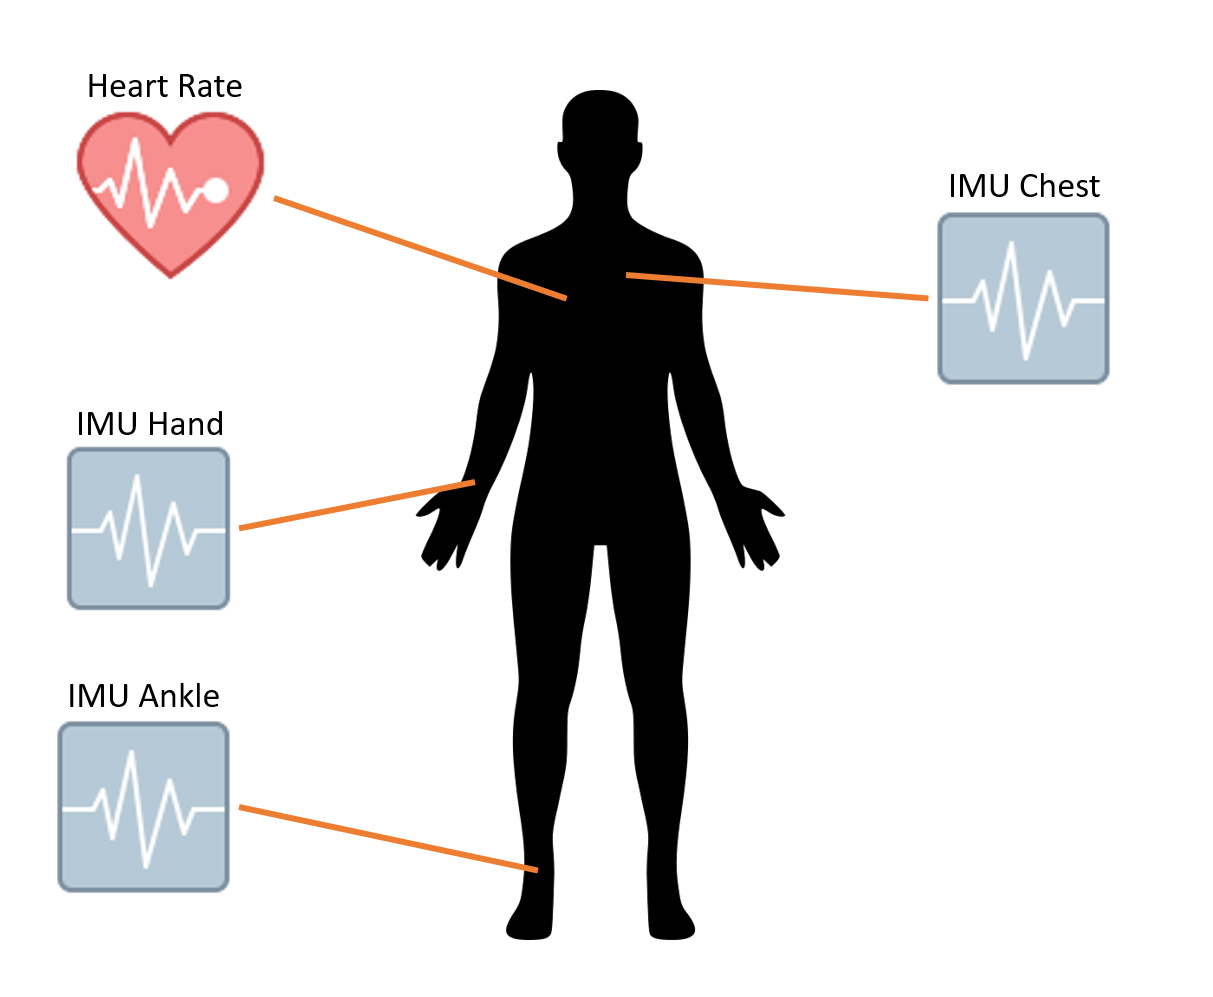

In [1]:
#Libraries used in the report.

import numpy as np  
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import scipy.stats as stats #For the correlation matrix and calculation of the p-value

In [2]:
elementos= { 
"Subject_ID": [101,102,103,104,105,106,107,108,109],
"Sex":["Male","Female","Male","Male","Male","Male","Male","Male","Male"],
"Age (years)":[27,25, 31, 24,26,26,23,32,31],
"Height (cm)":[182,169,187,194,180,183,173,179,168],
"Weight (kg)":[83,78,92,95,73,69,86,87,65],
"Resting HR (bpm)":[75,74,68,58,70,60,60,66,54],
"Max HR (bpm)":[193,195,189,196,194,194,197,188,189],
"Dominant hand":["right","right","right","right","right","right","right","left","right"]
}

DimSubject=pd.DataFrame(elementos)

In [3]:
DimSubject

,Subject_ID,Sex,Age (years),Height (cm),Weight (kg),Resting HR (bpm),Max HR (bpm),Dominant hand
0,101,Male,27,182,83,75,193,right
1,102,Female,25,169,78,74,195,right
2,103,Male,31,187,92,68,189,right
3,104,Male,24,194,95,58,196,right
4,105,Male,26,180,73,70,194,right
5,106,Male,26,183,69,60,194,right
6,107,Male,23,173,86,60,197,right
7,108,Male,32,179,87,66,188,left
8,109,Male,31,168,65,54,189,right


In [4]:
elementos= { 
"activityID": [1,2,3,4,5,6,7,9,10,11,12,13,16,17,18,19,20,24,0],
"activity":["lying","sitting","standing","walking","running","cycling","Nordic walking","watching TV","computer work","car driving","ascending stairs","descending stairs","vacuum cleaning","ironing","folding laundry","house cleaning","playing soccer","rope jumping","other (transient activities)"],
}

DimActivity=pd.DataFrame(elementos)
                   


In [5]:
DimActivity

,activityID,activity
0,1,lying
1,2,sitting
2,3,standing
3,4,walking
4,5,running
5,6,cycling
6,7,Nordic walking
7,9,watching TV
8,10,computer work
9,11,car driving


In [6]:
import pandas as pd

files=['subject101','subject102','subject103','subject104','subject105','subject106','subject107','subject108','subject109']

colNames = ["timestamp", "activityID","heartrate"]

IMUhand = ['handTemperature', 
           'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
           'handGyro1', 'handGyro2', 'handGyro3', 
           'handMagne1', 'handMagne2', 'handMagne3',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

IMUchest = ['chestTemperature', 
           'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
           'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
           'chestGyro1', 'chestGyro2', 'chestGyro3', 
           'chestMagne1', 'chestMagne2', 'chestMagne3',
           'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

IMUankle = ['ankleTemperature', 
           'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
           'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
           'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
           'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
           'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

Additional_Columns=['Subject_ID']

columnsname = colNames + IMUhand + IMUchest + IMUankle + Additional_Columns #all columns in one list
 
for i in files:
    locals()["df"+"_"+str(i)] = pd.read_table(str(i)+".dat", 
                     header=None,
                     sep = "\s+",
                     #columns=columnsname
                    )
    locals()["df"+"_"+str(i)][54]=i[-3::]

In [7]:
frames=[df_subject101,df_subject102,df_subject103,df_subject104,df_subject105,df_subject106,df_subject107,df_subject108,df_subject109]

#this merges all the frames (for each subject) into a single frame
df_full = pd.concat(frames)

df_full.columns = columnsname

In [8]:
df_full=pd.merge(df_full,DimActivity, on='activityID', how='inner')

In [9]:
df_full

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,Subject_ID,activity
0,8.38,0,104.0,30.000,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,-0.017580,-61.1888,-38.959900,-58.143800,1.000000,0.000000,0.000000,0.000000,101,other (transient activities)
1,8.39,0,NaN,30.000,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,0.000368,-59.8479,-38.891900,-58.525300,1.000000,0.000000,0.000000,0.000000,101,other (transient activities)
2,8.40,0,NaN,30.000,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.022495,-60.7361,-39.413800,-58.399900,1.000000,0.000000,0.000000,0.000000,101,other (transient activities)
3,8.41,0,NaN,30.000,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,0.011275,-60.4091,-38.763500,-58.395600,1.000000,0.000000,0.000000,0.000000,101,other (transient activities)
4,8.42,0,NaN,30.000,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.002823,-61.5199,-39.387900,-58.269400,1.000000,0.000000,0.000000,0.000000,101,other (transient activities)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872528,95.06,24,NaN,25.125,4.99466,6.01881,5.59830,4.90787,6.05780,5.68357,...,0.005878,-45.7855,-0.831734,-0.170139,0.522929,-0.291612,0.705786,-0.378648,109,rope jumping
2872529,95.07,24,NaN,25.125,5.02764,5.90369,5.48372,4.89090,5.95209,5.56301,...,-0.004235,-46.0331,-0.817288,0.538134,0.522880,-0.291694,0.705895,-0.378450,109,rope jumping
2872530,95.08,24,NaN,25.125,5.06409,5.71370,5.48491,4.97981,5.87584,5.45738,...,-0.002309,-45.5140,-1.229410,0.540438,0.522625,-0.291978,0.706161,-0.378084,109,rope jumping
2872531,95.09,24,162.0,25.125,5.13914,5.63724,5.48629,4.97690,5.69448,5.29167,...,-0.007076,-45.9093,-0.565555,0.680109,0.522536,-0.291955,0.706426,-0.377733,109,rope jumping


In [10]:
df_full['heartrate']=df_full.heartrate.ffill(axis = 0)
#df_full['heartrate'] = df['BrandName'].replace(['ABC', 'AB'], 'A')

In [11]:
df_full

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,Subject_ID,activity
0,8.38,0,104.0,30.000,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,-0.017580,-61.1888,-38.959900,-58.143800,1.000000,0.000000,0.000000,0.000000,101,other (transient activities)
1,8.39,0,104.0,30.000,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,0.000368,-59.8479,-38.891900,-58.525300,1.000000,0.000000,0.000000,0.000000,101,other (transient activities)
2,8.40,0,104.0,30.000,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.022495,-60.7361,-39.413800,-58.399900,1.000000,0.000000,0.000000,0.000000,101,other (transient activities)
3,8.41,0,104.0,30.000,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,0.011275,-60.4091,-38.763500,-58.395600,1.000000,0.000000,0.000000,0.000000,101,other (transient activities)
4,8.42,0,104.0,30.000,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.002823,-61.5199,-39.387900,-58.269400,1.000000,0.000000,0.000000,0.000000,101,other (transient activities)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872528,95.06,24,162.0,25.125,4.99466,6.01881,5.59830,4.90787,6.05780,5.68357,...,0.005878,-45.7855,-0.831734,-0.170139,0.522929,-0.291612,0.705786,-0.378648,109,rope jumping
2872529,95.07,24,162.0,25.125,5.02764,5.90369,5.48372,4.89090,5.95209,5.56301,...,-0.004235,-46.0331,-0.817288,0.538134,0.522880,-0.291694,0.705895,-0.378450,109,rope jumping
2872530,95.08,24,162.0,25.125,5.06409,5.71370,5.48491,4.97981,5.87584,5.45738,...,-0.002309,-45.5140,-1.229410,0.540438,0.522625,-0.291978,0.706161,-0.378084,109,rope jumping
2872531,95.09,24,162.0,25.125,5.13914,5.63724,5.48629,4.97690,5.69448,5.29167,...,-0.007076,-45.9093,-0.565555,0.680109,0.522536,-0.291955,0.706426,-0.377733,109,rope jumping


In [12]:
df_full.count()

timestamp            2872533
activityID           2872533
heartrate            2872533
handTemperature      2859392
handAcc16_1          2859392
handAcc16_2          2859392
handAcc16_3          2859392
handAcc6_1           2859392
handAcc6_2           2859392
handAcc6_3           2859392
handGyro1            2859392
handGyro2            2859392
handGyro3            2859392
handMagne1           2859392
handMagne2           2859392
handMagne3           2859392
handOrientation1     2859392
handOrientation2     2859392
handOrientation3     2859392
handOrientation4     2859392
chestTemperature     2868970
chestAcc16_1         2868970
chestAcc16_2         2868970
chestAcc16_3         2868970
chestAcc6_1          2868970
chestAcc6_2          2868970
chestAcc6_3          2868970
chestGyro1           2868970
chestGyro2           2868970
chestGyro3           2868970
chestMagne1          2868970
chestMagne2          2868970
chestMagne3          2868970
chestOrientation1    2868970
chestOrientati

In [13]:
## removal of any NaN values across the dataset
df_full = df_full.dropna()
df_full.reset_index(drop = True, inplace = True)

In [14]:
df_full = df_full[df_full.activityID != 0]

In [15]:
## checking if any null values exist in dataframe
df_full.isnull().sum()

timestamp            0
activityID           0
heartrate            0
handTemperature      0
handAcc16_1          0
handAcc16_2          0
handAcc16_3          0
handAcc6_1           0
handAcc6_2           0
handAcc6_3           0
handGyro1            0
handGyro2            0
handGyro3            0
handMagne1           0
handMagne2           0
handMagne3           0
handOrientation1     0
handOrientation2     0
handOrientation3     0
handOrientation4     0
chestTemperature     0
chestAcc16_1         0
chestAcc16_2         0
chestAcc16_3         0
chestAcc6_1          0
chestAcc6_2          0
chestAcc6_3          0
chestGyro1           0
chestGyro2           0
chestGyro3           0
chestMagne1          0
chestMagne2          0
chestMagne3          0
chestOrientation1    0
chestOrientation2    0
chestOrientation3    0
chestOrientation4    0
ankleTemperature     0
ankleAcc16_1         0
ankleAcc16_2         0
ankleAcc16_3         0
ankleAcc6_1          0
ankleAcc6_2          0
ankleAcc6_3

In [16]:
result = df_full.groupby(['timestamp','Subject_ID','activity']).aggregate({'heartrate':'max'})
result =result.groupby(['Subject_ID','activity']).aggregate({'heartrate':'mean'}).apply(lambda x: x.sort_values(ascending=True))
result2 =result.groupby(['activity']).aggregate({'heartrate':'mean'}).apply(lambda x: x.sort_values(ascending=True))
print(result)

                          heartrate
Subject_ID activity                
107        lying          66.317766
106        lying          70.986927
107        sitting        71.699083
108        lying          73.583633
103        lying          74.031895
...                             ...
101        running       161.355976
105        rope jumping  163.556122
101        rope jumping  165.782641
108        running       166.347783
           rope jumping  174.311326

[91 rows x 1 columns]


# Exploratory Data Analysis


### Heart Rate

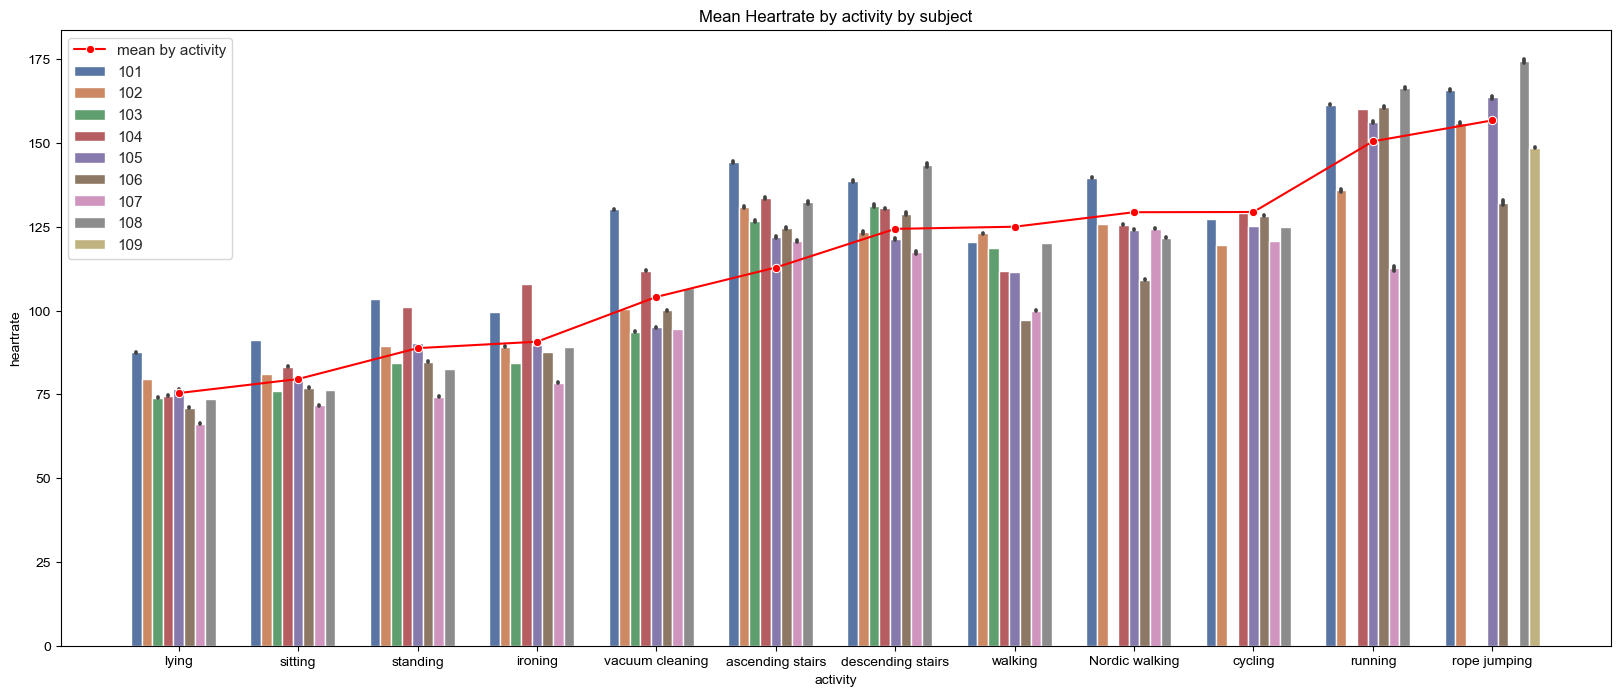

In [17]:
fig,axs = plt.subplots(ncols=1, figsize=(20,8))

sns.set_theme(style="whitegrid")
#custom_params = {"axes.spines.right": False, "axes.spines.top": False}
#sns.set_theme(style="ticks", rc=custom_params)
sns.barplot(data=df_full, x="activity", y="heartrate", hue="Subject_ID")
sns.lineplot( x = "activity", y = "heartrate", data = result2,ci=None,color='red',label='mean by activity',marker="o")
#sns.lineplot( x = "title_year", y = "budget", data = df_full,ci=None,label='budget',color='blue')
#sns.lineplot( x = "title_year", y = "gross", data = df_full,ci=None,label='gross',color='green')
plt.title("Mean Heartrate by activity by subject")
#fig.tight_layout()
plt.show()

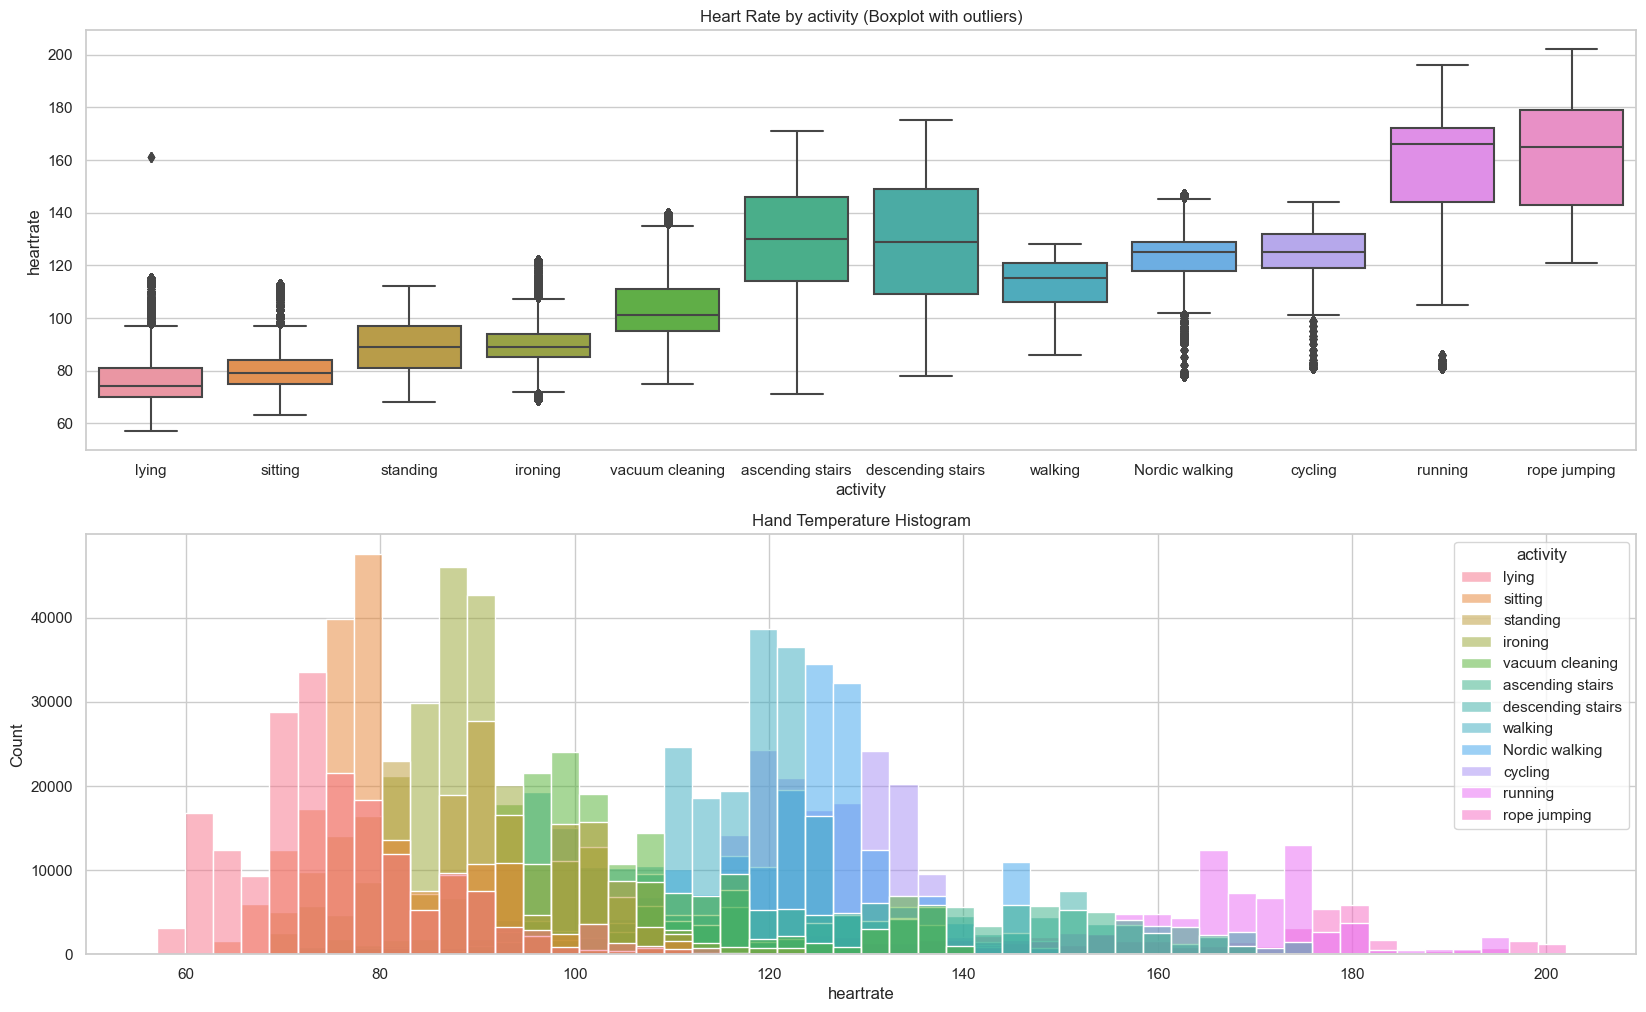

In [18]:
fig,axs = plt.subplots(nrows=2, figsize=(20,12))
sns.boxplot(x="activity", y="heartrate", data=df_full,showfliers=True,ax=axs[0])
sns.histplot(df_full, x="heartrate",bins=50,hue='activity',ax=axs[1]) 
axs[0].set_title('Heart Rate by activity (Boxplot with outliers)')
axs[1].set_title('Hand Temperature Histogram')                          
plt.show()

### Temperature

In [19]:
df1=df_full[['Subject_ID','handTemperature','activity']]
df1=df1.rename({'handTemperature': 'temperature'}, axis=1)
df1['bodyPart']='hand'

df2=df_full[['Subject_ID','chestTemperature','activity']]
df2=df2.rename({'chestTemperature': 'temperature'}, axis=1)
df2['bodyPart']='chest'

df3=df_full[['Subject_ID','ankleTemperature','activity']]
df3=df3.rename({'ankleTemperature': 'temperature'}, axis=1)
df3['bodyPart']='ankle'

concatTemperature = pd.concat([df1,df2,df3 ], ignore_index=True, sort=False)

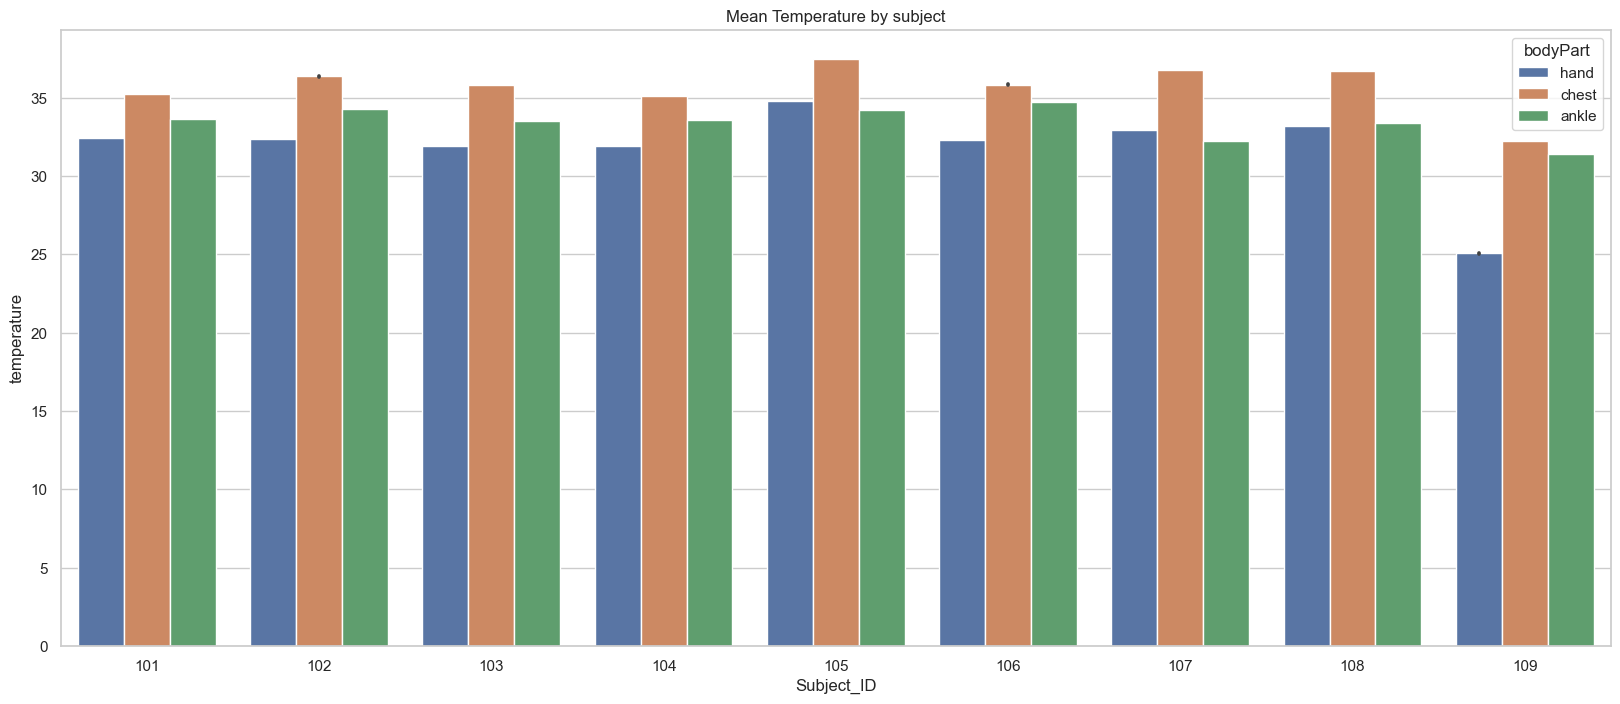

In [20]:
fig,axs = plt.subplots(ncols=1, figsize=(20,8))

sns.set_theme(style="whitegrid")
sns.barplot(x='Subject_ID', y="temperature", data=concatTemperature,hue='bodyPart')

plt.title("Mean Temperature by subject")
#fig.tight_layout()
plt.show()

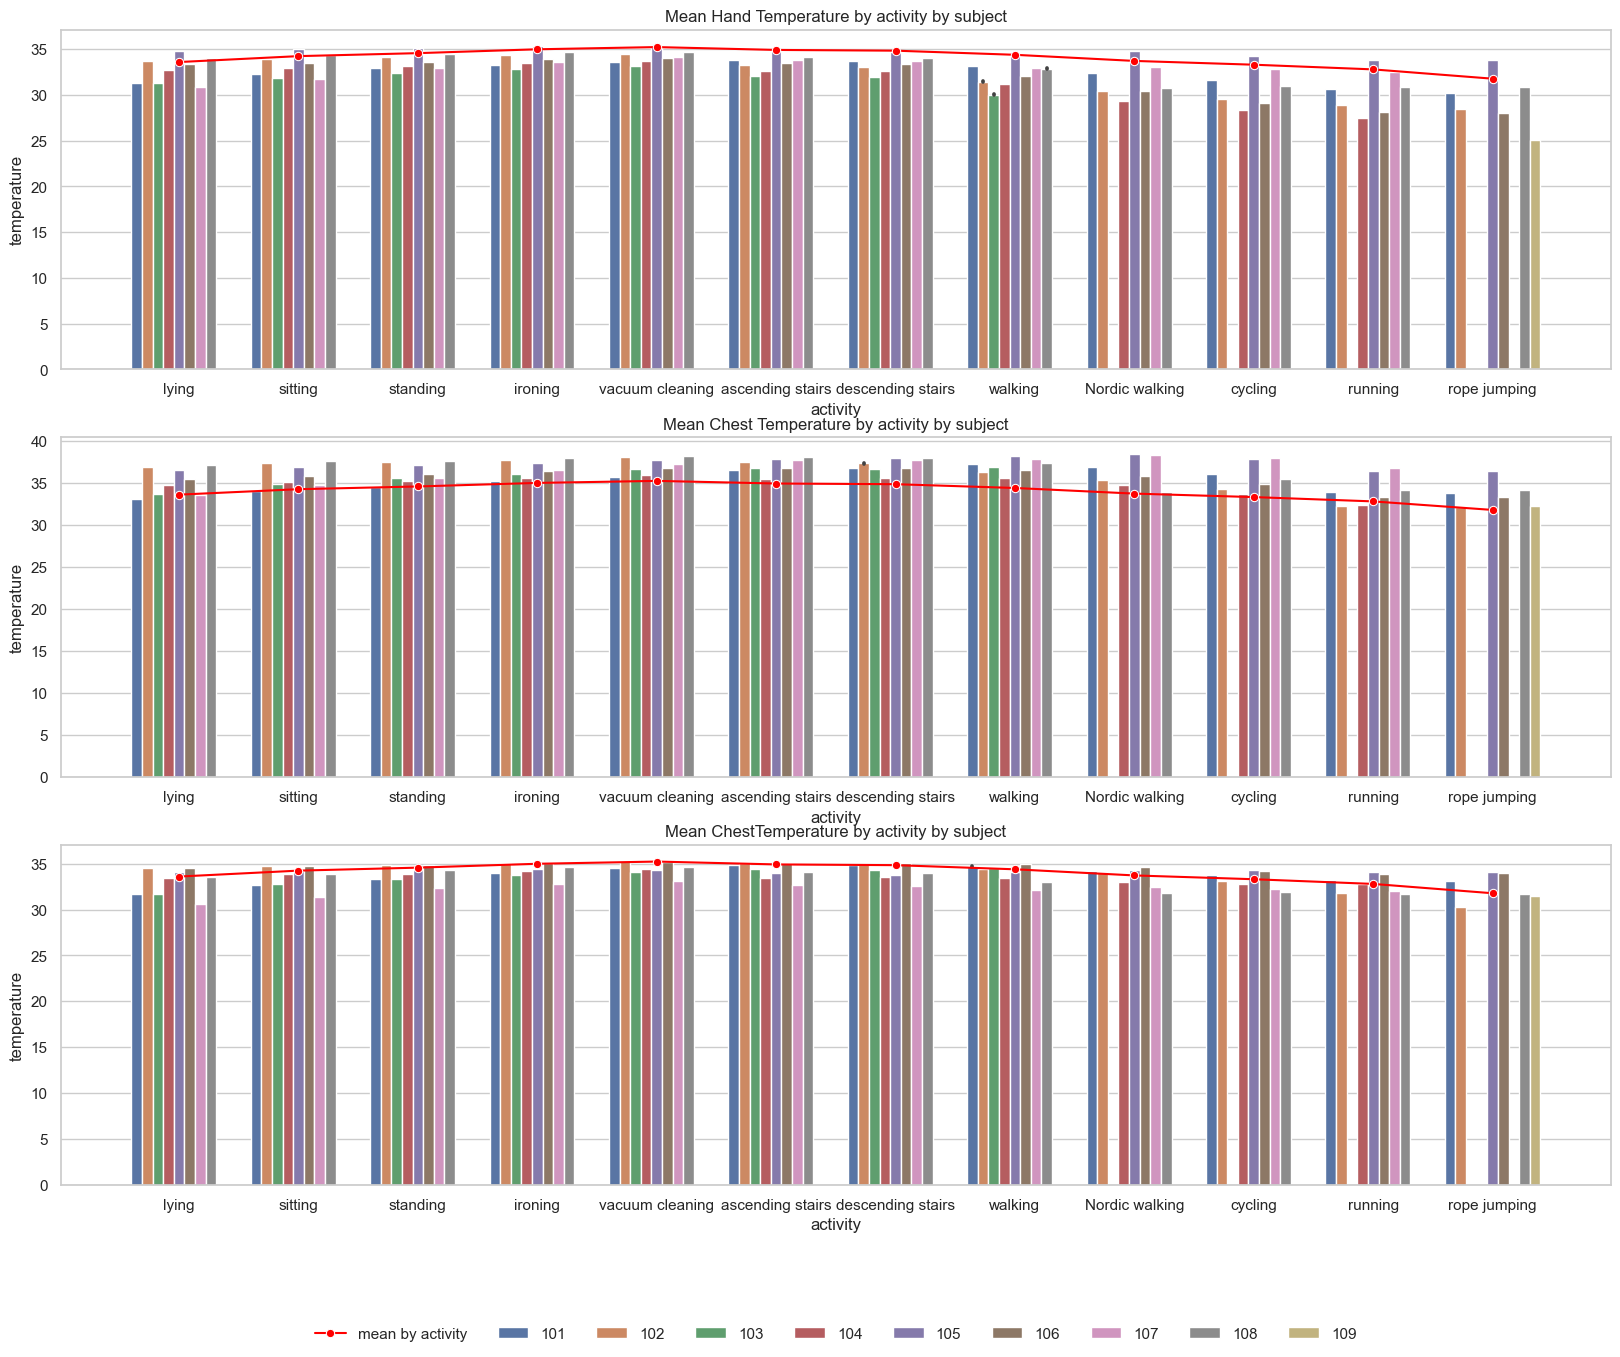

In [21]:
fig,axs = plt.subplots(nrows=3, figsize=(20,15))

#custom_params = {"axes.spines.right": False, "axes.spines.top": False}
#sns.set_theme(style="ticks", rc=custom_params)
sns.set_theme(style="whitegrid")

sns.barplot(x='activity', y="temperature", data=concatTemperature[(concatTemperature.bodyPart == "hand")],hue='Subject_ID',ax=axs[0])
sns.lineplot( x = "activity", y = "temperature", data = concatTemperature,ci=None,color='red',label='mean by activity',marker="o",ax=axs[0])
sns.move_legend(axs[0], "lower center",bbox_to_anchor=(.5, -0.5), ncol=10, title=None, frameon=False)

sns.barplot(x='activity', y="temperature", data=concatTemperature[(concatTemperature.bodyPart == "chest")],hue='Subject_ID',ax=axs[1])
sns.lineplot( x = "activity", y = "temperature", data = concatTemperature,ci=None,color='red',label='mean by activity',marker="o",ax=axs[1])
sns.move_legend(axs[1], "lower center", bbox_to_anchor=(.5, -0.5), ncol=10, title=None, frameon=False)

sns.barplot(x='activity', y="temperature", data=concatTemperature[(concatTemperature.bodyPart == "ankle")],hue='Subject_ID',ax=axs[2])
sns.lineplot( x = "activity", y = "temperature", data = concatTemperature,ci=None,color='red',label='mean by activity',marker="o",ax=axs[2])
sns.move_legend(axs[2], "lower center", bbox_to_anchor=(.5, -0.5), ncol=10, title=None, frameon=False)

#sns.move_legend(axs[2], "lower center",bbox_to_anchor=(.5, -0.5), ncol=3, title=None, frameon=False)
axs[0].set_title('Mean Hand Temperature by activity by subject')
axs[1].set_title('Mean Chest Temperature by activity by subject')           
axs[2].set_title('Mean ChestTemperature by activity by subject')  

#fig.tight_layout()
plt.show()

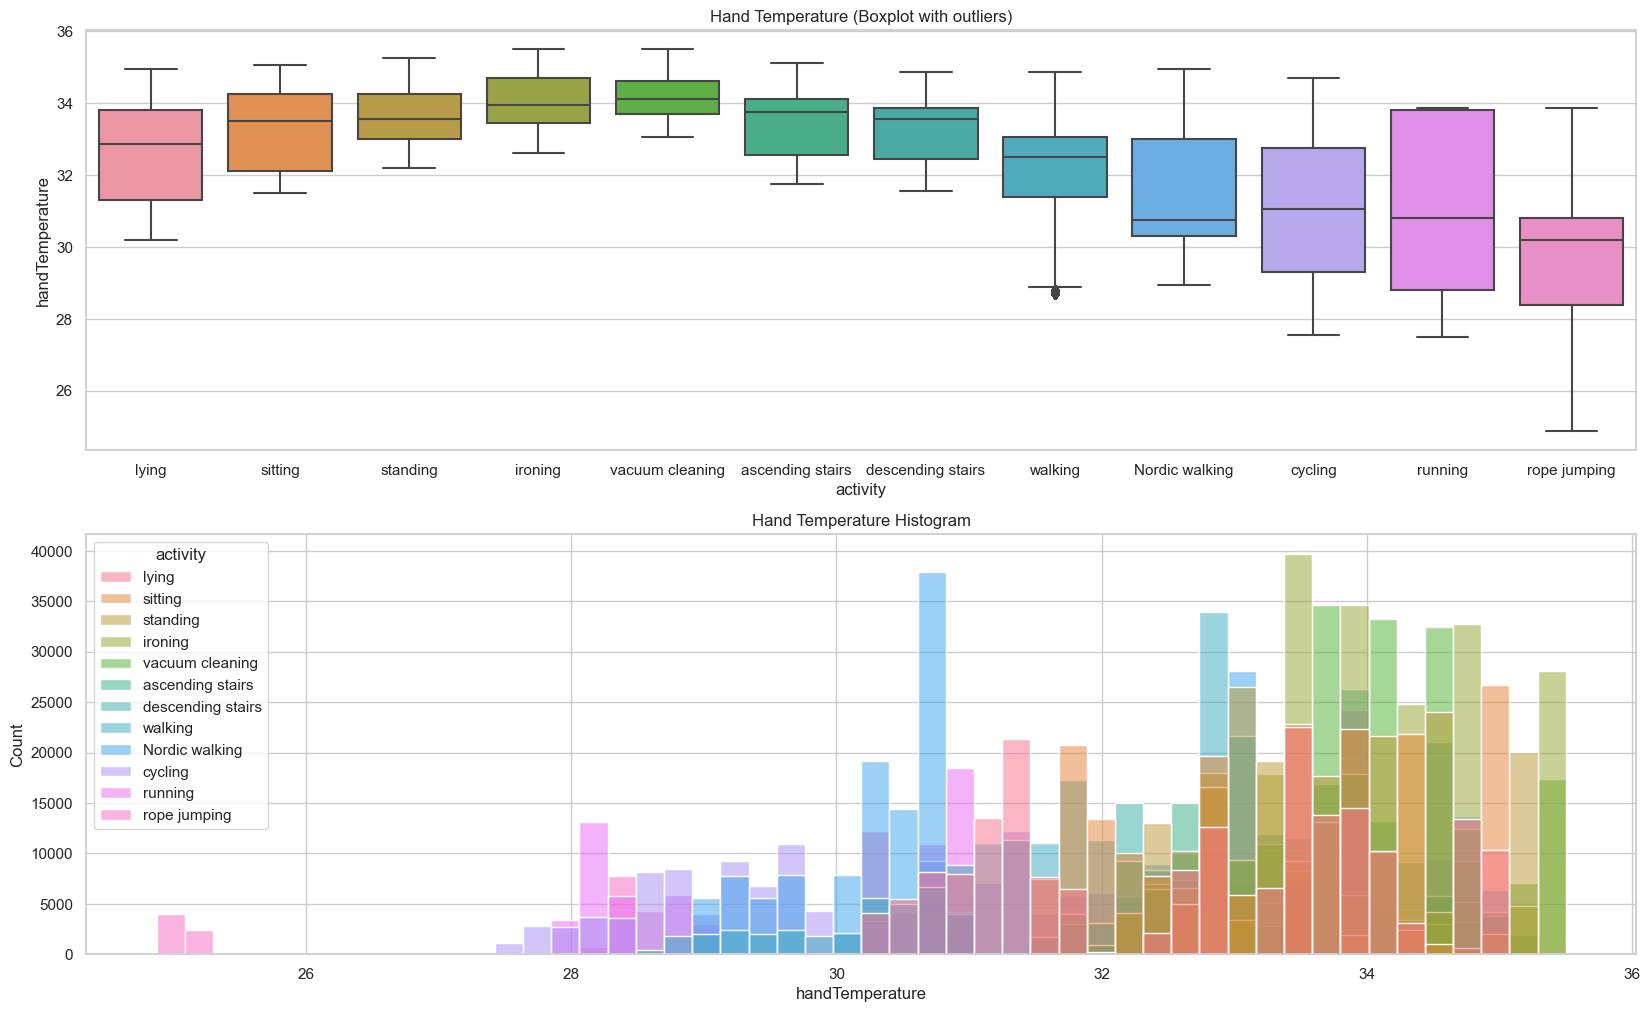

In [22]:
fig,axs = plt.subplots(nrows=2, figsize=(20,12))
sns.boxplot(x="activity", y="handTemperature", data=df_full,showfliers=True,ax=axs[0])
sns.histplot(df_full, x="handTemperature",bins=50,hue='activity',ax=axs[1]) 
axs[0].set_title('Hand Temperature (Boxplot with outliers)')
axs[1].set_title('Hand Temperature Histogram')                          
plt.show()

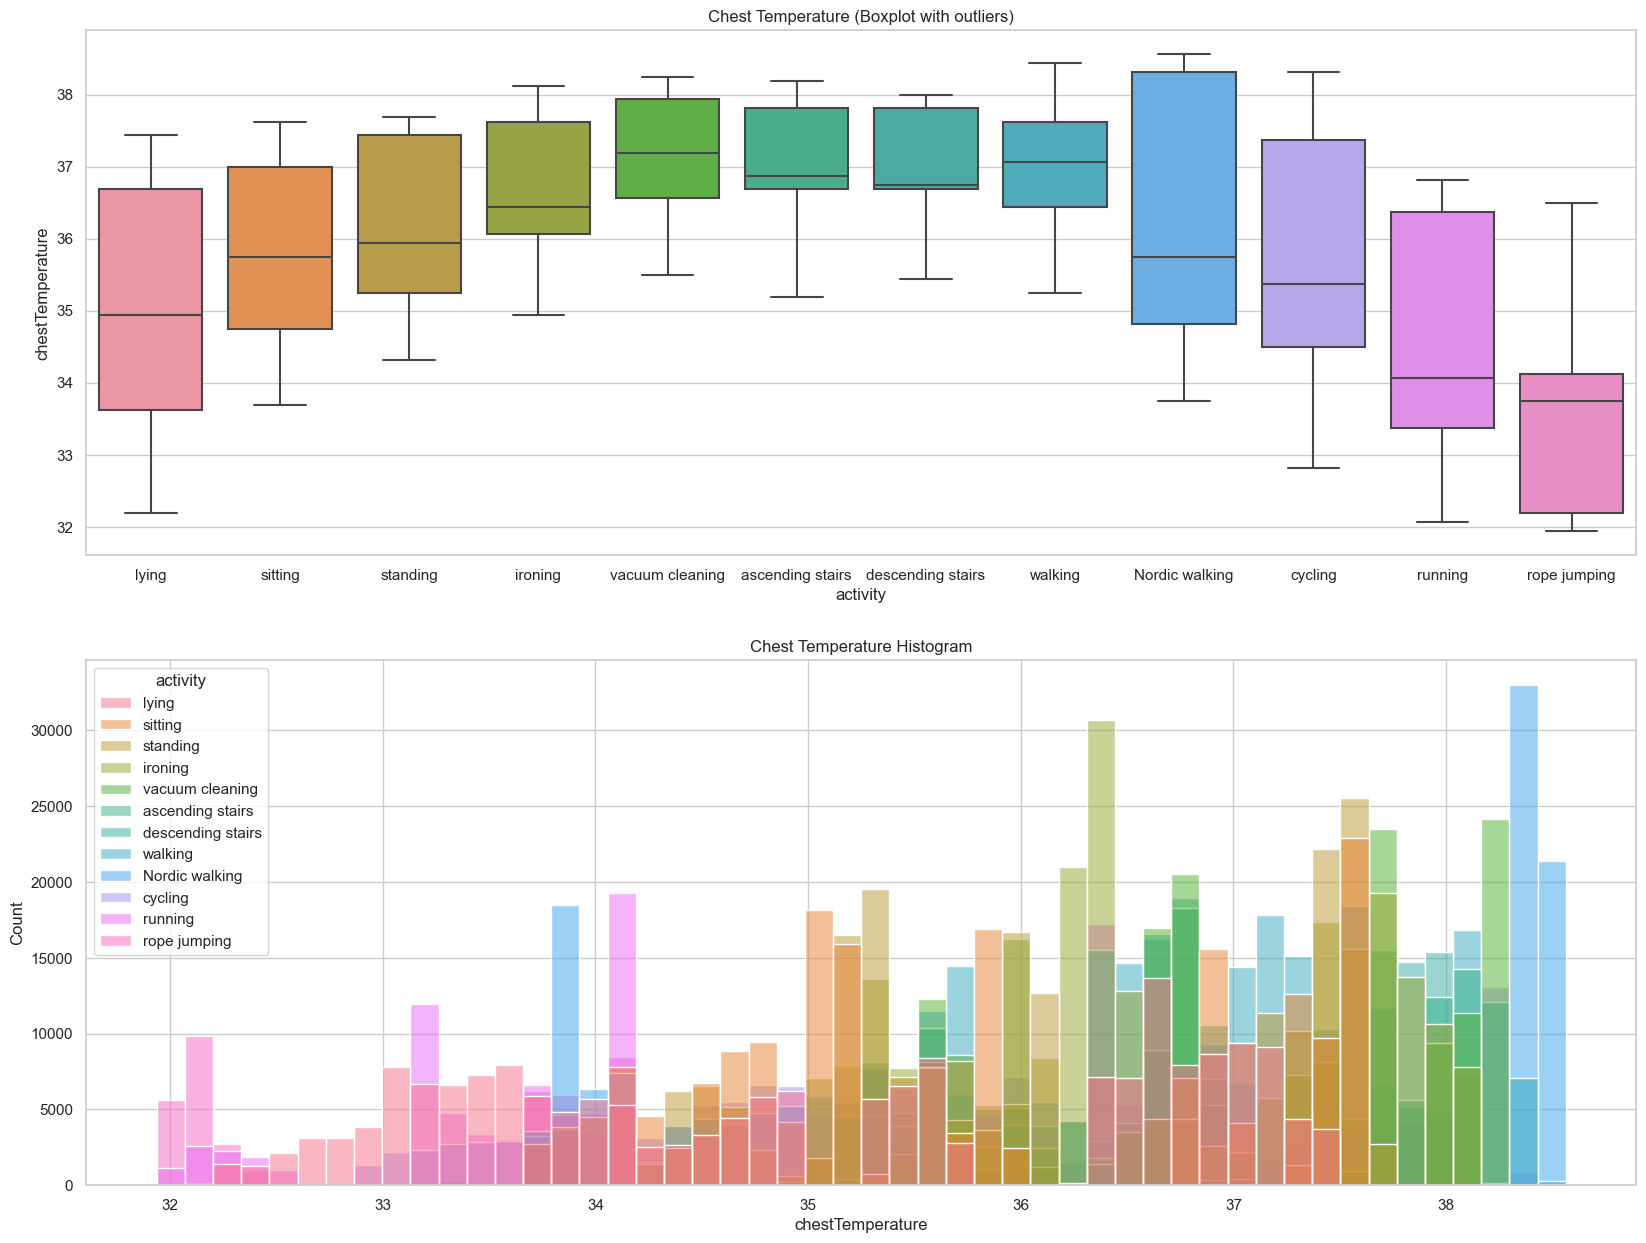

In [23]:
fig,axs = plt.subplots(nrows=2, figsize=(20,15))
sns.boxplot(x="activity", y="chestTemperature", data=df_full,showfliers=True,ax=axs[0])
sns.histplot(df_full, x="chestTemperature",bins=50,hue='activity',ax=axs[1]) 
axs[0].set_title('Chest Temperature (Boxplot with outliers)')
axs[1].set_title('Chest Temperature Histogram')                          
plt.show()

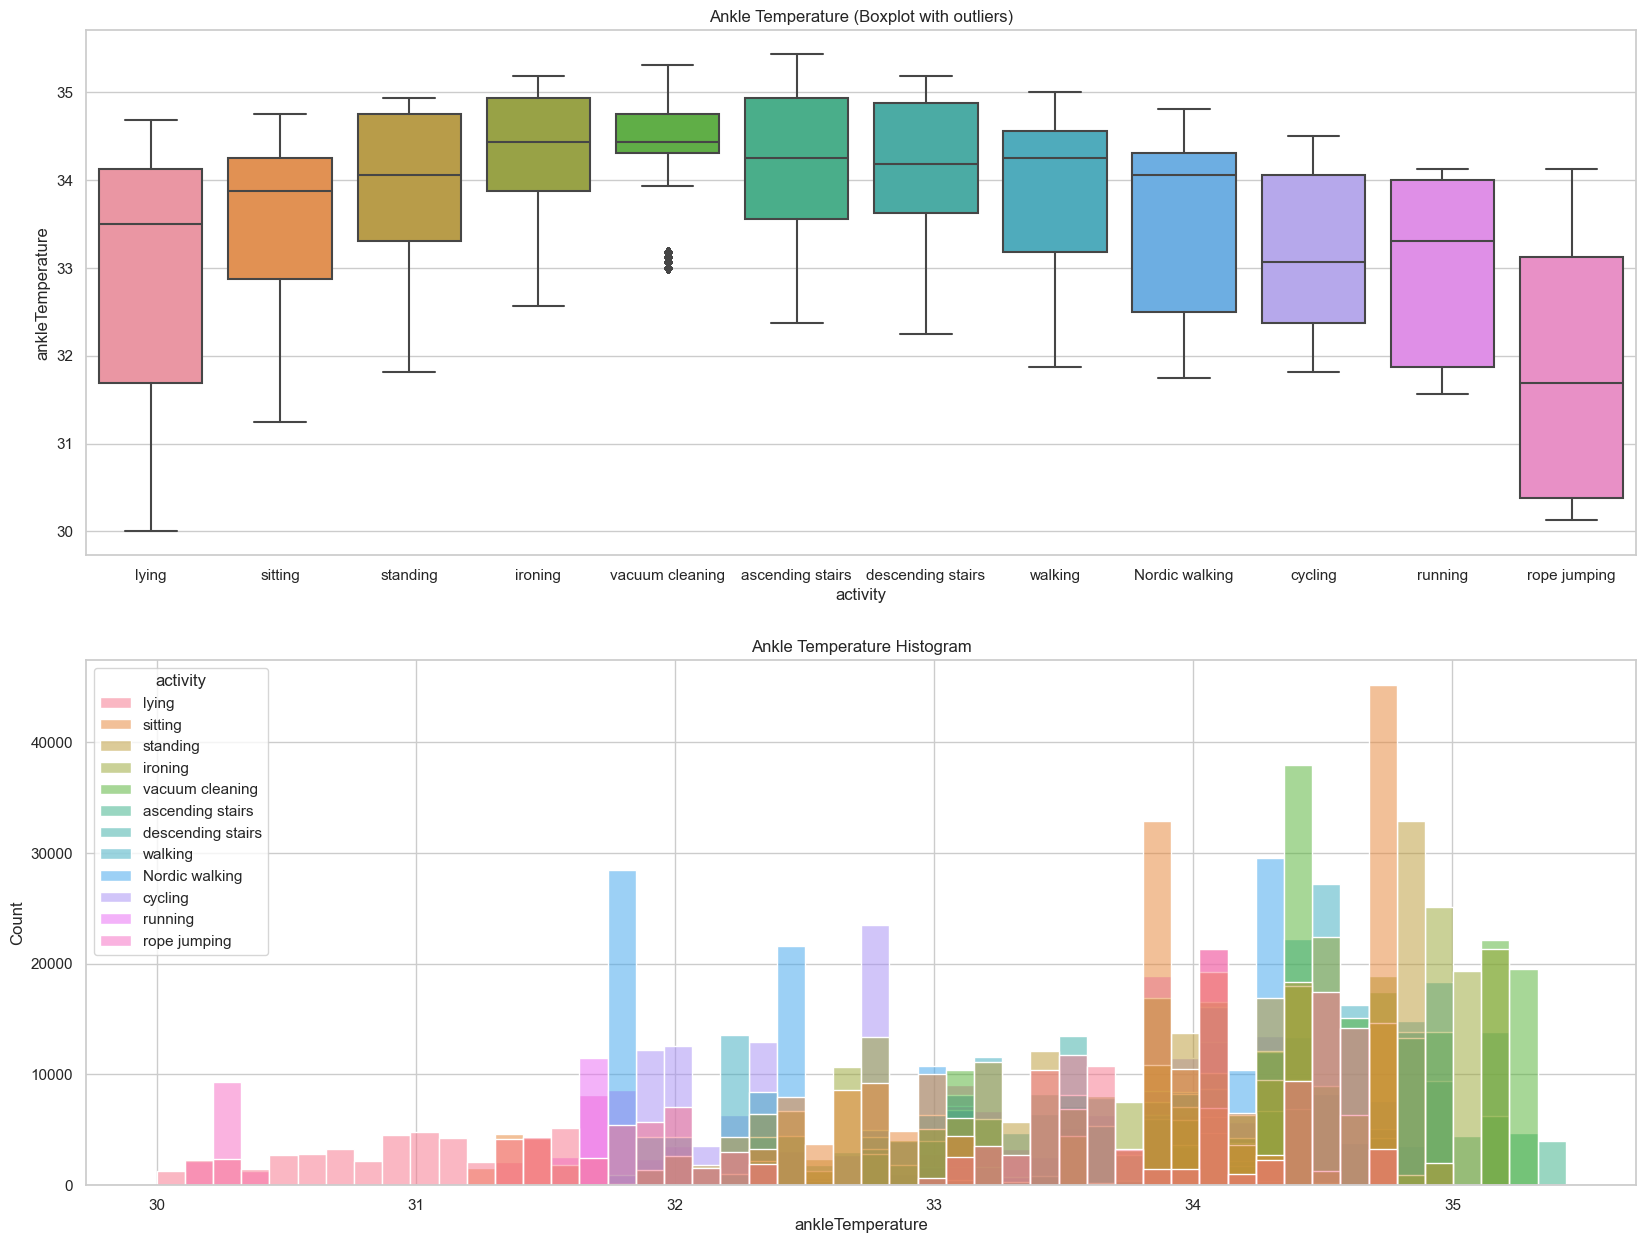

In [24]:
fig,axs = plt.subplots(nrows=2, figsize=(20,15))
sns.boxplot(x="activity", y="ankleTemperature", data=df_full,showfliers=True,ax=axs[0])
sns.histplot(df_full, x="ankleTemperature",bins=50,hue='activity',ax=axs[1]) 
axs[0].set_title('Ankle Temperature (Boxplot with outliers)')
axs[1].set_title('Ankle Temperature Histogram')                          
plt.show()

 sns.pairplot(df_full, vars = ['heartrate','handTemperature','handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
                   'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
           'handGyro1', 'handGyro2', 'handGyro3', 
           'handMagne1', 'handMagne2', 'handMagne3',
             'chestTemperature',
                   'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
           'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
           'chestGyro1', 'chestGyro2', 'chestGyro3', 
           'chestMagne1', 'chestMagne2', 'chestMagne3',
             'ankleTemperature', 
           'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
           'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
           'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
           'ankleMagne1', 'ankleMagne2', 'ankleMagne3'], size = 10)
plt.show()

In [25]:
concatTemperature

,Subject_ID,temperature,activity,bodyPart
0,101,30.375,lying,hand
1,101,30.375,lying,hand
2,101,30.375,lying,hand
3,101,30.375,lying,hand
4,101,30.375,lying,hand
...,...,...,...,...
5764288,109,31.500,rope jumping,ankle
5764289,109,31.500,rope jumping,ankle
5764290,109,31.500,rope jumping,ankle
5764291,109,31.500,rope jumping,ankle


In [26]:
df_full

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,Subject_ID,activity
923437,37.66,1,161.0,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,0.001752,-61.1081,-36.863600,-58.369600,1.000000,0.000000,0.000000,0.000000,101,lying
923438,37.67,1,161.0,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,0.006007,-60.8916,-36.319700,-58.365600,1.000000,0.000000,0.000000,0.000000,101,lying
923439,37.68,1,161.0,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,-0.004882,-60.3407,-35.784200,-58.611900,1.000000,0.000000,0.000000,0.000000,101,lying
923440,37.69,1,161.0,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,0.026950,-60.7646,-37.102800,-57.879900,1.000000,0.000000,0.000000,0.000000,101,lying
923441,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,-0.006328,-60.2040,-37.122500,-57.884700,1.000000,0.000000,0.000000,0.000000,101,lying
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2844863,95.06,24,162.0,25.125,4.99466,6.01881,5.59830,4.90787,6.05780,5.68357,...,0.005878,-45.7855,-0.831734,-0.170139,0.522929,-0.291612,0.705786,-0.378648,109,rope jumping
2844864,95.07,24,162.0,25.125,5.02764,5.90369,5.48372,4.89090,5.95209,5.56301,...,-0.004235,-46.0331,-0.817288,0.538134,0.522880,-0.291694,0.705895,-0.378450,109,rope jumping
2844865,95.08,24,162.0,25.125,5.06409,5.71370,5.48491,4.97981,5.87584,5.45738,...,-0.002309,-45.5140,-1.229410,0.540438,0.522625,-0.291978,0.706161,-0.378084,109,rope jumping
2844866,95.09,24,162.0,25.125,5.13914,5.63724,5.48629,4.97690,5.69448,5.29167,...,-0.007076,-45.9093,-0.565555,0.680109,0.522536,-0.291955,0.706426,-0.377733,109,rope jumping


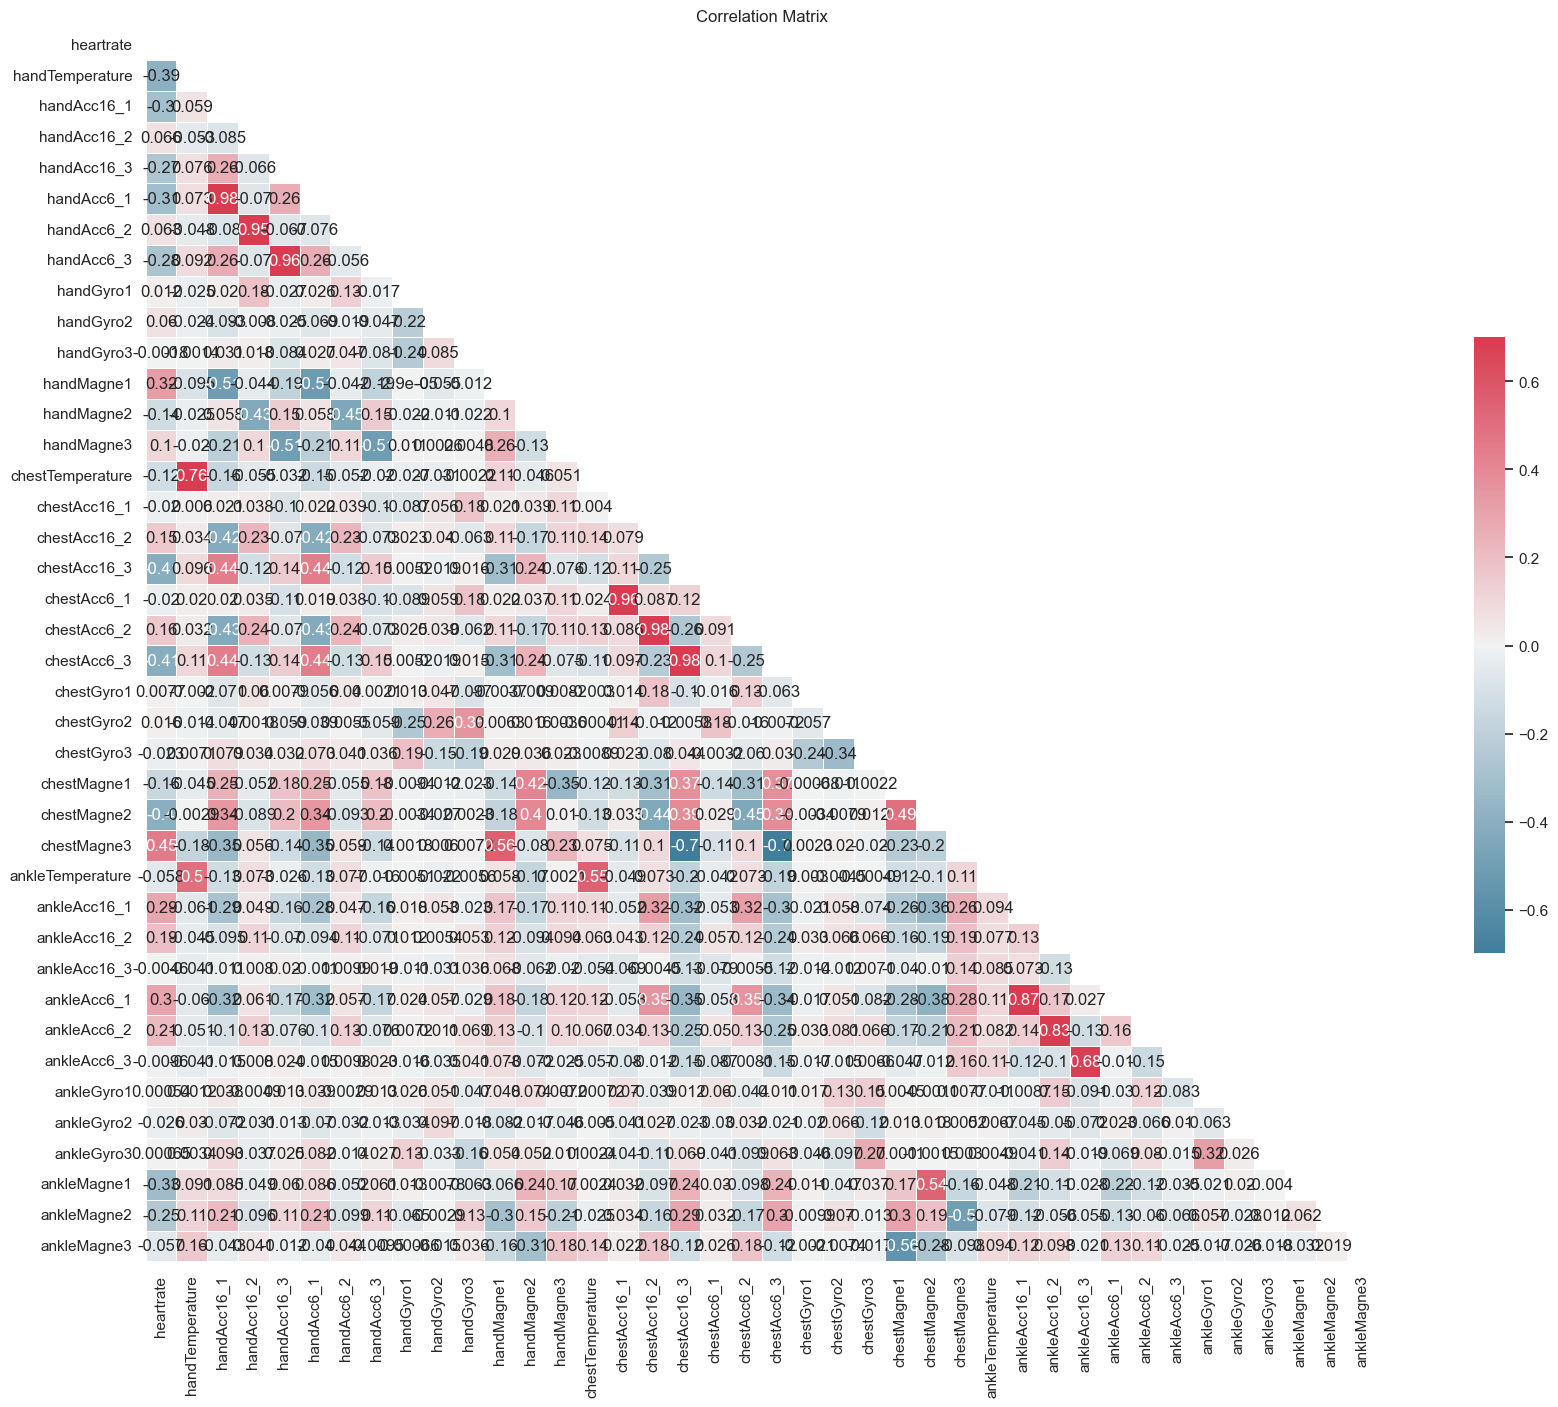

In [83]:
corr=df_full[['heartrate','handTemperature','handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
                   'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
           'handGyro1', 'handGyro2', 'handGyro3', 
           'handMagne1', 'handMagne2', 'handMagne3',
             'chestTemperature',
                   'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
           'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
           'chestGyro1', 'chestGyro2', 'chestGyro3', 
           'chestMagne1', 'chestMagne2', 'chestMagne3',
             'ankleTemperature', 
           'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
           'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
           'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
           'ankleMagne1', 'ankleMagne2', 'ankleMagne3']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 16))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 8, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot = True)
plt.title("Correlation Matrix")
plt.show()

# Model to predict Heart Rate

## Linear regresion model

In [31]:
# Regresión Lineal
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics
X = df_full[['chestMagne3','handTemperature','chestMagne2','chestAcc16_3','chestAcc6_3','ankleAcc6_1','ankleAcc6_2','ankleAcc6_3']]
y = df_full['heartrate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print()
print("*** Coeficientes Linear Regression ***")
print(linreg.intercept_)
print(linreg.coef_)
print()
RMSE_linreg = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
print('Linear Regression (RMSE): ', RMSE_linreg)


*** Coeficientes Linear Regression ***
252.93872245150277
[ 0.35550716 -5.0492198  -0.45673182  0.11459148 -0.35256298  0.29993302
  0.15186901 -0.55129558]

Linear Regression (RMSE):  20.394072799758423


In [32]:
print('Coefficient de correlacion PEARSON (LINREG):', linreg.score(X,y))

Coefficient de correlacion PEARSON (LINREG): 0.42756907289262713


In [33]:
y_pred

array([ 62.66330343, 101.47487774,  97.98834154, ...,  91.43939475,
        77.80298681,  92.44011991])

In [34]:
#Regresion lineal con el 100% de los datos
import statsmodels.formula.api as smf

lm = smf.ols(formula="heartrate ~ chestMagne3 + handTemperature + chestMagne2 + chestAcc16_3 + chestAcc6_3 + ankleAcc6_1 + ankleAcc6_2 + ankleAcc6_3", data=df_full).fit()
lm.params

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              heartrate   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                 1.794e+05
Date:                Sat, 24 Dec 2022   Prob (F-statistic):               0.00
Time:                        18:41:41   Log-Likelihood:            -8.5210e+06
No. Observations:             1921431   AIC:                         1.704e+07
Df Residuals:                 1921422   BIC:                         1.704e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         252.9234      0.277    914.088      0.000     252.381     253.466
chestMagne3         0.3559      0.001    363.250      0.000       0.354       0.358
handTemperature    -5.0487      0.008   -602.142      0.000      -5.065      -5.032
chestMagne2        -0.4564      0.001   -473.865      0.000      -0.458      -0.455
chestAcc16_3        0.1197      0.018      6.624      0.000       0.084       0.155
chestAcc6_3        -0.3574      0.018    -19.866      0.000      -0.393      -0.322
ankleAcc6_1         0.2993      0.003    109.182      0.000       0.294       0.305
ankleAcc6_2         0.1529      0.002     69.577      0.000       0.149       0.157
ankleAcc6_3        -0.5563      0.004   -126.010      0.000      -0.565      -0.548
==============================================================================
Omnibus:                   264280.254   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           429929.463
Skew:                           0.949   Prob(JB):                         0.00
Kurtosis:                       4.329   Cond. No.                         904.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
features = pd.get_dummies(df_full)

In [44]:
features

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,activity_cycling,activity_descending stairs,activity_ironing,activity_lying,activity_rope jumping,activity_running,activity_sitting,activity_standing,activity_vacuum cleaning,activity_walking
923437,37.66,1,161.0,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,0,0,0,1,0,0,0,0,0,0
923438,37.67,1,161.0,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,0,0,0,1,0,0,0,0,0,0
923439,37.68,1,161.0,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,0,0,0,1,0,0,0,0,0,0
923440,37.69,1,161.0,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,0,0,0,1,0,0,0,0,0,0
923441,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2844863,95.06,24,162.0,25.125,4.99466,6.01881,5.59830,4.90787,6.05780,5.68357,...,0,0,0,0,1,0,0,0,0,0
2844864,95.07,24,162.0,25.125,5.02764,5.90369,5.48372,4.89090,5.95209,5.56301,...,0,0,0,0,1,0,0,0,0,0
2844865,95.08,24,162.0,25.125,5.06409,5.71370,5.48491,4.97981,5.87584,5.45738,...,0,0,0,0,1,0,0,0,0,0
2844866,95.09,24,162.0,25.125,5.13914,5.63724,5.48629,4.97690,5.69448,5.29167,...,0,0,0,0,1,0,0,0,0,0


## Random forests (decision trees) model

In [45]:
# Variable que queremos predecir. 
labels = np.array(features['heartrate'])

#Eliminar la variable a predecir del dataset original (axis 1 indica que es una columna).
features= features.drop('heartrate', axis = 1)
#features= features.drop('timestamp', axis = 1)
#features= features.drop('activityID', axis = 1)
#Guardar como una lista las variables independientes. 
feature_list = list(features.columns)

#Convertir las caracteristicas a NP array
features = np.array(features)


In [46]:
# Genere un conjunto de entrenamiento y validación. 
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 42)

In [47]:
print('Dimensiones de la data del conjunto de entrenamiento:', train_features.shape)
print('Dimensiones de las Etiquetas de la data del conjunto de entrenamiento:', train_labels.shape)
print('Dimensiones de la data del conjunto de prueba:', test_features.shape)
print('Dimensiones de las Etiquetas de la data del conjunto de prueba:', test_labels.shape)

Dimensiones de la data del conjunto de entrenamiento: (1441073, 74)
Dimensiones de las Etiquetas de la data del conjunto de entrenamiento: (1441073,)
Dimensiones de la data del conjunto de prueba: (480358, 74)
Dimensiones de las Etiquetas de la data del conjunto de prueba: (480358,)


In [48]:
from sklearn.ensemble import RandomForestRegressor

#Generar una instancia del modelo RandomForestRegressor
rf =RandomForestRegressor(n_estimators=10, max_depth = 3, random_state=42)

#Entrenar el modelo con el conjunto de pruebas
rf.fit(train_features, train_labels);

In [49]:
#Hacer predicciones con los datos de prueba
predictions = rf.predict(test_features)
#Calcular las diferencias en terminos absolutos
errors = abs(predictions - test_labels)
#Entregar el Error Absoluto Medio (mae)
print('Error Absoluto Medio (mae):', round(np.mean(errors), 2), 'grados')

Error Absoluto Medio (mae): 10.38 grados


In [50]:
# Determine el rendimiento del modelo.
mape = 100 * (errors / test_labels)

# Calculate la precision
accuracy = 100 - np.mean(mape)
print('Precision (Accuracy):', round(accuracy, 2), '%.')

Precision (Accuracy): 90.39 %.


In [80]:
#Extraer por separado year, month, day
timestamp_real = features[:, feature_list.index('timestamp')]
#days = features[:, feature_list.index('day')]
#years = features[:, feature_list.index('year')]

#Generar string de fechas como YYYY-MM-DD
dates = [timestamp for timestamp in zip(timestamp_real)]

#Se genera una lista para convertir a formato datetime.
#dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

#Dataframe con los datos registrados y sus fechas
true_data = pd.DataFrame(data = {'time': timestamp_real, 'real': labels})

#Extraer por separado year, month, day del conjunto de Entrenamiento
timestamp_test = test_features[:, feature_list.index('timestamp')]
#days = test_features[:, feature_list.index('day')]
#years = test_features[:, feature_list.index('year')]

#Generar string de fechas como YYYY-MM-DD del conjunto de Test
#test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

#Se genera una lista para convertir a formato datetime del conjunto de Entrenamiento
#test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

#Dataframe con los datos predecidos y sus fechas
predictions_data = pd.DataFrame(data = {'time': timestamp_test, 'prediction': predictions})
true_data

,time,real
0,37.66,161.0
1,37.67,161.0
2,37.68,161.0
3,37.69,161.0
4,37.70,100.0
...,...,...
1921426,95.06,162.0
1921427,95.07,162.0
1921428,95.08,162.0
1921429,95.09,162.0


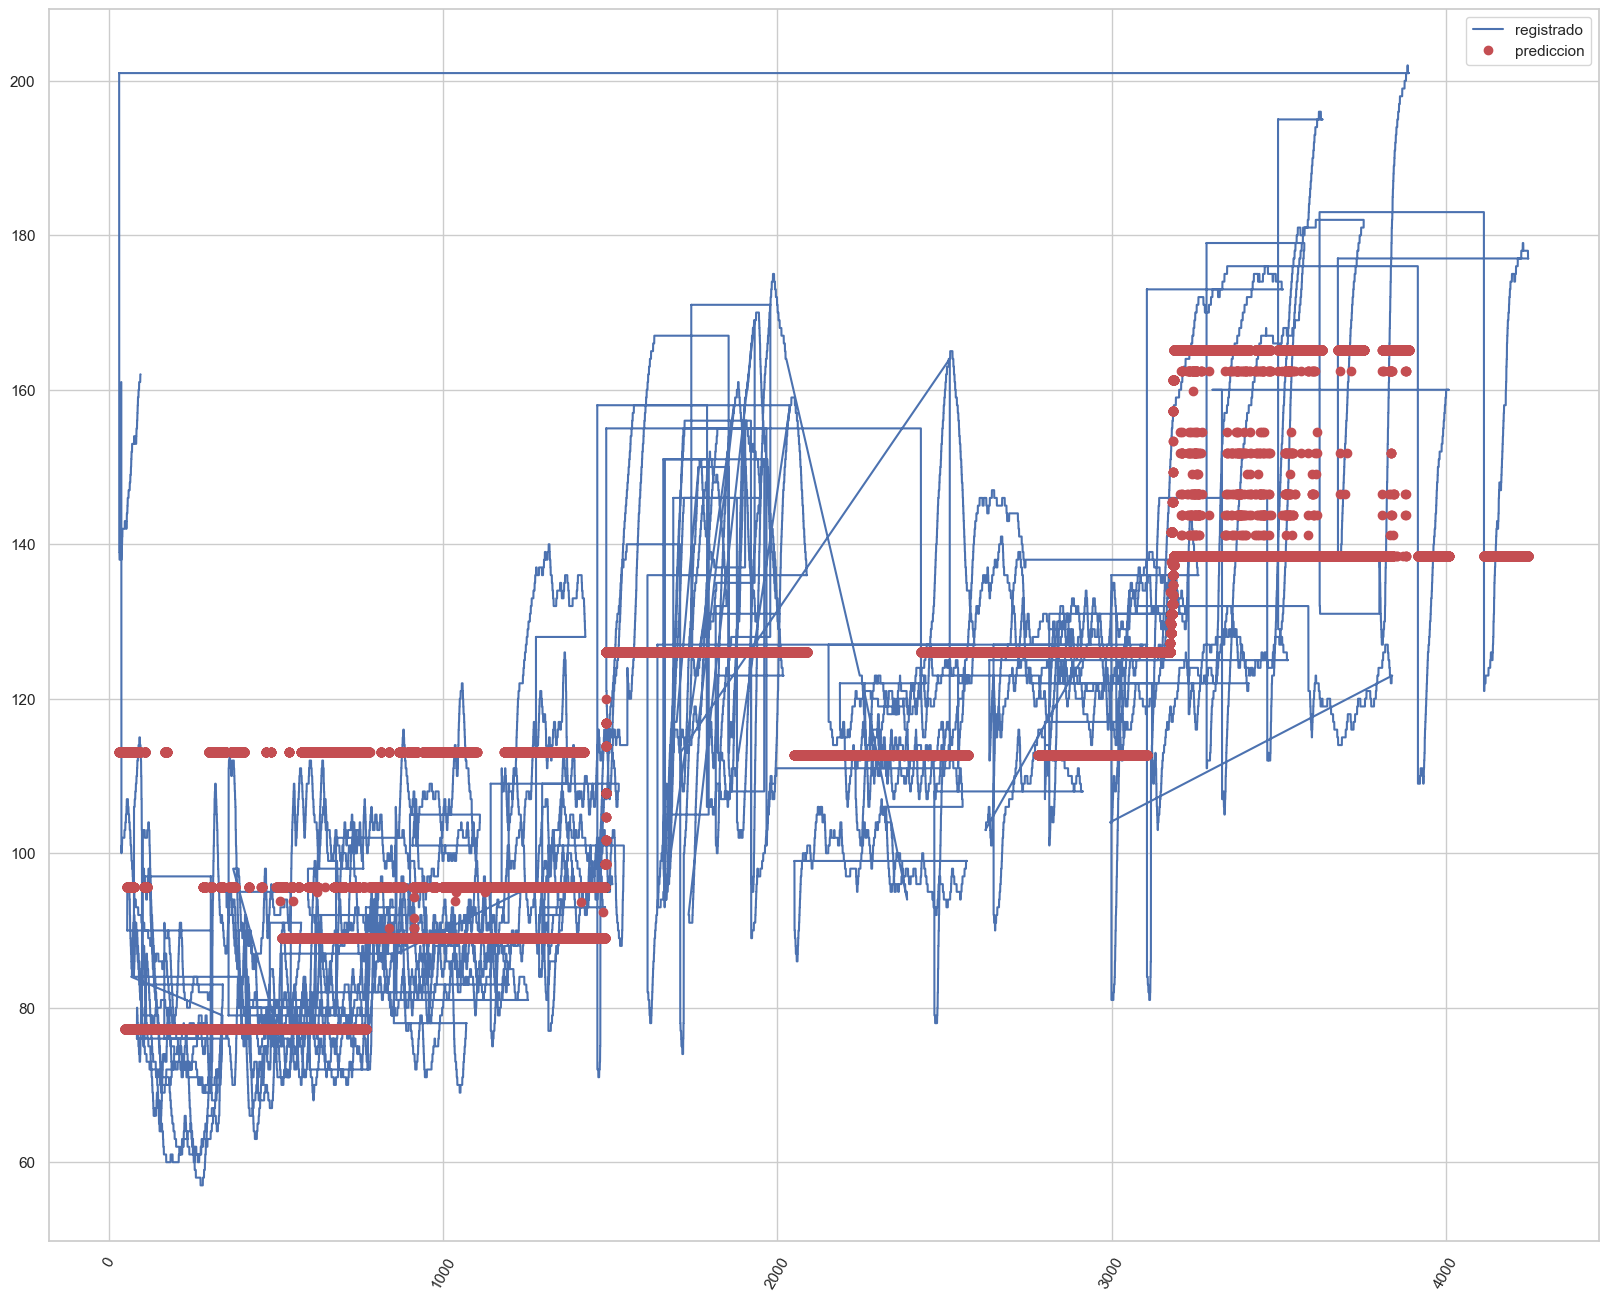

In [84]:
#Graficar los valores registrados
f, ax = plt.subplots(figsize=(20, 16))
plt.plot(true_data['time'], true_data['real'], 'b-', label = 'registrado')

#Graficar los valores predecidos
plt.plot(predictions_data['time'], predictions_data['prediction'], 'ro', label = 'prediccion')
plt.xticks(rotation = '60'); 
plt.legend()

#Etiquetas del grafico
#plt.xlabel('Periodo'); plt.ylabel('Temperatura Máxima (F)'); plt.title('Valores Registrados v/s Predecidos');

# Model to classify activities

In [85]:
activity_id = {0: 'transient', 1:'lying', 2:'sitting', 3:'standing',
              4:'walking', 5:'running', 6:'cycling', 7:'Nordic walking',
              9:'watching TV', 10:'computer work', 11:'car driving',
              12:'ascending stairs', 13:'descending stairs', 16:'vacuum cleaning',
              17:'ironing', 18:'folding laundry', 19:'house cleaning',
              20:'playing soccer', 24:'rope jumping'}

protocol_acts = [1,2,3,4,5,6,7,17,16,24,12,13]


In [86]:
activity_id[1]

'lying'

In [87]:
[activity_id[x] for x in protocol_acts]

['lying',
 'sitting',
 'standing',
 'walking',
 'running',
 'cycling',
 'Nordic walking',
 'ironing',
 'vacuum cleaning',
 'rope jumping',
 'ascending stairs',
 'descending stairs']

In [88]:
def confusion_matrix(predict_labels, real_labels, cats, title):
    """
    Function used to display confusion matrix from a set of predicted and real labels. Displays a confusion matrix,
    then uses sklearn library utilities to calculate accuracy, precision, recall and F-score from the data.
    
    Params:
    predict_labels: array of labels predicted by model
    real_labels: array of real labels
    cats: categories for rows and columns of confusion matrix. If false, activity data from protocol activities are used.
    title: title of confusion matrix.
    
    """ 
    pred_results = {}
    base_dict = {}
    
    #If cats parameter is False, the matrix is created with activity data from protocol activities
    if not cats:
        for i in protocol_acts:
            base_dict[i]=0
        for i in protocol_acts:
            pred_results[i] = base_dict.copy()
    else:
        for i in cats:
            base_dict[i]=0
        for i in cats:
            pred_results[i] = base_dict.copy()
    
    #Dictionary is created counting real values for predicted labels
    for pl,tl in list(zip(predict_labels,  real_labels)):
        pred_results[pl][tl]+=1

    pred_results_df = pd.DataFrame(pred_results)
    if not cats:
        pred_results_df.columns=[activity_id[x] for x in protocol_acts]
        pred_results_df.index = [activity_id[x] for x in protocol_acts]
    
    #Accuracy, precision, recall and f-score are calculated using sklearn library
    precision = precision_score(real_labels, predict_labels, average='macro')
    recall = recall_score(real_labels, predict_labels, average='macro')
    accuracy = accuracy_score(real_labels, predict_labels)
    fscore = f1_score(real_labels, predict_labels, average='macro')
    
    #Display results
    print((title))
    display((pred_results_df))
    print(('Accuracy: ' + str(accuracy)))
    print(('Precision: ' + str(precision)))
    print(('Recall: ' + str(recall)))
    print(('F-score: ' + str(fscore)))    

In [89]:
#Using a seed to facilitate replication of results
dev_data_df = df_full.sample(frac=0.7, random_state=1)
test_data_df = df_full.drop(dev_data_df.index)

In [40]:
from sklearn import tree
tclf = tree.DecisionTreeClassifier()

In [41]:
features_used = ['handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
           'handGyro1', 'handGyro2', 'handGyro3', 
           'handMagne1', 'handMagne2', 'handMagne3'
                ]
label_col = 'activity'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
tclf.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = tclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for Decision Tree using Accelerometer features")

KeyError: 'lying'